In [33]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

# Data Preparation

In [34]:
path = '../input/fashion-product-images-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']

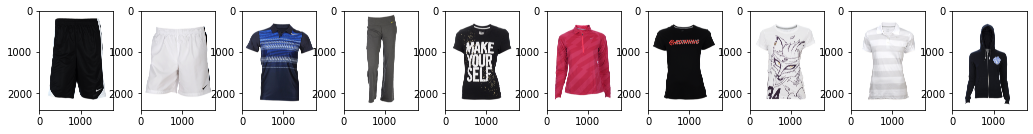

In [35]:
# Plot samples 
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100' + str(i) +'.jpg') # Assign images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [36]:
styles_df = pd.read_csv(path + "styles.csv", nrows=6000, error_bad_lines=False) # Read 6000 product and drop bad lines 
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
print(styles_df.shape)
styles_df.head(5)

(6000, 11)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


<AxesSubplot:>

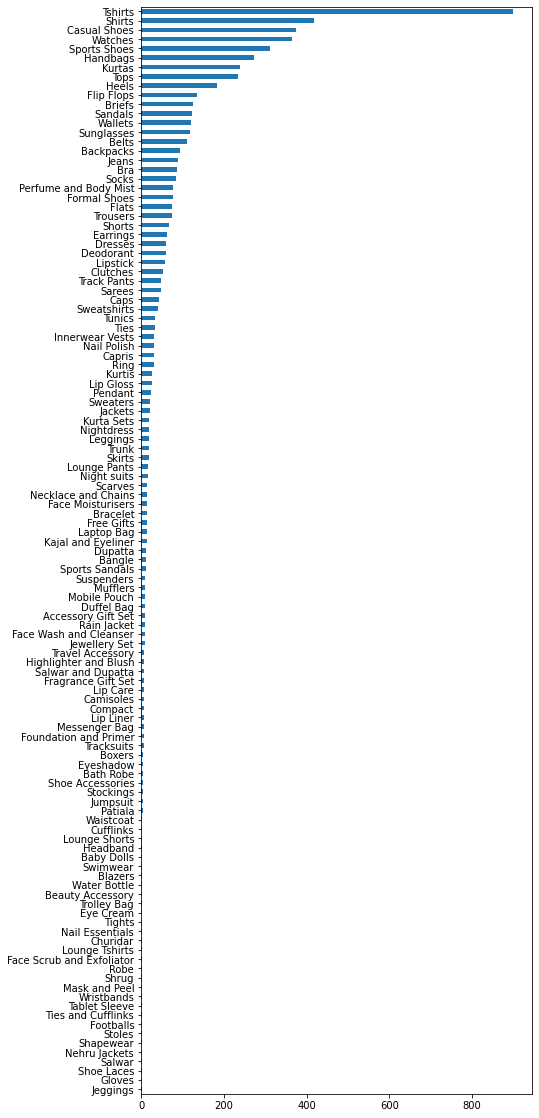

In [37]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

# Modeling and Get Image Embeddings

In [38]:
img_width, img_height, chnls = 100, 100, 3

In [39]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input dimensions
img_width, img_height = 224, 224
chnls = 3

# Load ResNet50 model with custom weights
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, chnls))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Create custom model
inputs = base_model.input
outputs = base_model.output

# Add GlobalMaxPooling2D layer
x = GlobalMaxPooling2D()(outputs)

# Create the model
vgg16_model = Model(inputs=inputs, outputs=x)

# Print model summary
vgg16_model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
vgg16_model.compile(optimizer=optimizer)

# Function to load custom weights
def load_custom_weights(vgg16_model):
    # Replace '/path/to/local/file/resnet50_weights.h5' with the actual path to your downloaded file
    weights_path = '/kaggle/input/vgg16_model_tf/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    vgg16_model.load_weights(weights_path, by_name=True)

# Load custom weights
load_custom_weights(vgg16_model)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [40]:
# #VGG16
# from tensorflow.keras.applications import VGG16
# import tensorflow as tf

# model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
# my_model_1 = ResNet50(weights='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
# vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
# vgg16.trainable=False
# vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
# vgg16_model.summary()

In [41]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + 'images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [42]:
def get_embeddings(df, model):
    """ Return a dataframe contains images features """
    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

In [43]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.055423,0.062526,0.129065,0.042419,0.131590,0.053246,0.113200,0.014149,0.113624,0.018502,...,0.076053,0.471075,0.139049,0.070318,0.053135,0.117749,0.150147,0.078552,0.227247,0.132167
1,0.060313,0.052911,0.115841,0.036942,0.088067,0.049949,0.125341,0.007318,0.096096,0.016720,...,0.091157,0.449642,0.132824,0.067279,0.056607,0.121628,0.108797,0.067847,0.247827,0.103115
2,0.032286,0.049244,0.113207,0.035842,0.173687,0.053286,0.112340,0.013372,0.092192,0.010953,...,0.069782,0.351696,0.099637,0.067947,0.048757,0.107386,0.056580,0.059591,0.232310,0.118003
3,0.042937,0.050430,0.117376,0.037097,0.161119,0.049794,0.136055,0.006485,0.101852,0.017517,...,0.076737,0.359917,0.148488,0.071597,0.041447,0.112756,0.099146,0.068986,0.192578,0.116608
4,0.097409,0.058105,0.160763,0.042204,0.124324,0.051354,0.123861,0.011994,0.100067,0.015740,...,0.079548,0.417387,0.155460,0.079572,0.046434,0.101066,0.159843,0.061531,0.201702,0.128168


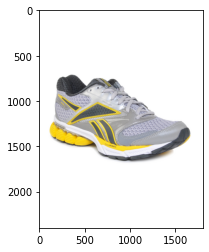

In [44]:
url="../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [45]:
sample_image = predict(vgg16_model, '10037.jpg')
sample_image.shape

(1, 2048)

In [46]:
df_sample_image = pd.DataFrame(sample_image)  
print(df_sample_image)

       0         1         2         3         4         5         6     \
0  0.032837  0.060077  0.136653  0.047402  0.169817  0.052572  0.104593   

      7         8        9     ...      2038      2039      2040      2041  \
0  0.01419  0.094892  0.01538  ...  0.081725  0.373538  0.074731  0.058802   

       2042      2043     2044      2045      2046      2047  
0  0.054683  0.093611  0.06246  0.063267  0.186309  0.118654  

[1 rows x 2048 columns]


In [47]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[75.73013  69.85257  67.8933   ... 49.623524 70.06758  70.43771 ]]


In [48]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10037.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [49]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [50]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(70, 1.0), (3395, 0.89464533), (4032, 0.8847675), (48, 0.8780232), (4645, 0.8720228)]


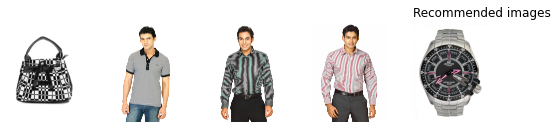

In [51]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# Reusable class for production

In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """
    
    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    # Helper functions 
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000, error_bad_lines=False) # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df
    
    def load_model(self):
        """ Load our model """
        # Define input dimensions
        img_width, img_height = 224, 224
        chnls = 3

        # Load ResNet50 model with custom weights
        base_model = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, chnls))

        # Freeze layers
        for layer in base_model.layers:
            layer.trainable = False

        # Create custom model
        inputs = base_model.input
        outputs = base_model.output

        # Add GlobalMaxPooling2D layer
        x = GlobalMaxPooling2D()(outputs)

        # Create the model
        vgg16_model = Model(inputs=inputs, outputs=x)

        # Print model summary
        vgg16_model.summary()

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        vgg16_model.compile(optimizer=optimizer)

        # Function to load custom weights
        def load_custom_weights(vgg16_model):
            # Replace '/path/to/local/file/resnet50_weights.h5' with the actual path to your downloaded file
            weights_path = '/kaggle/input/vgg16_model_tf/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
            vgg16_model.load_weights(weights_path, by_name=True)

        # Load custom weights
        load_custom_weights(vgg16_model)

        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100))
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)
    
    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity
    
    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm
    
    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]
    
    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("../input/fashion-product-images-dataset/fashion-dataset/" + 'images/'+ i)
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()
        return 

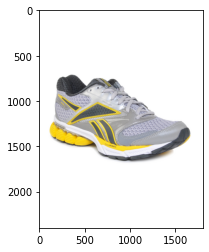

In [2]:
url = "../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [3]:
img_path = '../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg'
styles_path = '../input/fashion-product-images-dataset/fashion-dataset/styles.csv'
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()

NameError: name 'df_embeddings' is not defined